In [26]:
%matplotlib inline

# Familiar libraries.
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_mldata
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn import cross_validation
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
import time

# Take a moment to install Theano.  We will use it for building neural networks.
import theano 
from theano import tensor as T
from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams
print theano.config.device # We're using CPUs (for now)
print theano.config.floatX # Should be 64 bit for CPUs

np.random.seed(0)

gpu
float32


In [27]:
# Load the kaggle training dataset
all_train_data = np.genfromtxt("training.csv", delimiter=",", skip_header=1, usecols=(30)
                           , converters={ 30: lambda x : x.replace(" ", ",") })

# Convert all values to float and rescale from 0-1
# Theano is using float32, so downcast
all_train_data = np.array(map(lambda x : np.array(x.split(",")).astype(float) / 255, all_train_data), dtype=np.float32)
all_train_labels = np.genfromtxt("training.csv", delimiter=",", skip_header=1, usecols=np.arange(30), dtype=np.float32)

# Rescale our coordinates from -1 to 1
all_train_labels = (all_train_labels - 48) / 48
shuffle = np.random.permutation(np.arange(len(all_train_data)))

# Split training dataset into train, dev, test
train_data, train_labels = all_train_data[shuffle[:5000]], all_train_labels[shuffle[:5000]]
dev_data, dev_labels = all_train_data[shuffle[5000:6000]], all_train_labels[shuffle[5000:6000]]
test_data, test_labels = all_train_data[shuffle[6000:]], all_train_labels[shuffle[6000:]]

# Load the kaggle test dataset
kaggle_test_data = np.genfromtxt("test.csv", delimiter=",", skip_header=1, usecols=(1), \
    converters= { 1: lambda x : x.replace(" ", ",") }, dtype=np.float32)
kaggle_test_data = np.array(map(lambda x : np.array(x.split(",")).astype(float) / 255, kaggle_test_data), dtype=np.float32)

print train_data.shape
print train_labels.shape

(5000, 9216)
(5000, 30)


{0: 'left_eye_center_x', 1: 'left_eye_center_y', 2: 'right_eye_center_x', 3: 'right_eye_center_y', 4: 'left_eye_inner_corner_x', 5: 'left_eye_inner_corner_y', 6: 'left_eye_outer_corner_x', 7: 'left_eye_outer_corner_y', 8: 'right_eye_inner_corner_x', 9: 'right_eye_inner_corner_y', 10: 'right_eye_outer_corner_x', 11: 'right_eye_outer_corner_y', 12: 'left_eyebrow_inner_end_x', 13: 'left_eyebrow_inner_end_y', 14: 'left_eyebrow_outer_end_x', 15: 'left_eyebrow_outer_end_y', 16: 'right_eyebrow_inner_end_x', 17: 'right_eyebrow_inner_end_y', 18: 'right_eyebrow_outer_end_x', 19: 'right_eyebrow_outer_end_y', 20: 'nose_tip_x', 21: 'nose_tip_y', 22: 'mouth_left_corner_x', 23: 'mouth_left_corner_y', 24: 'mouth_right_corner_x', 25: 'mouth_right_corner_y', 26: 'mouth_center_top_lip_x', 27: 'mouth_center_top_lip_y', 28: 'mouth_center_bottom_lip_x', 29: 'mouth_center_bottom_lip_y'}


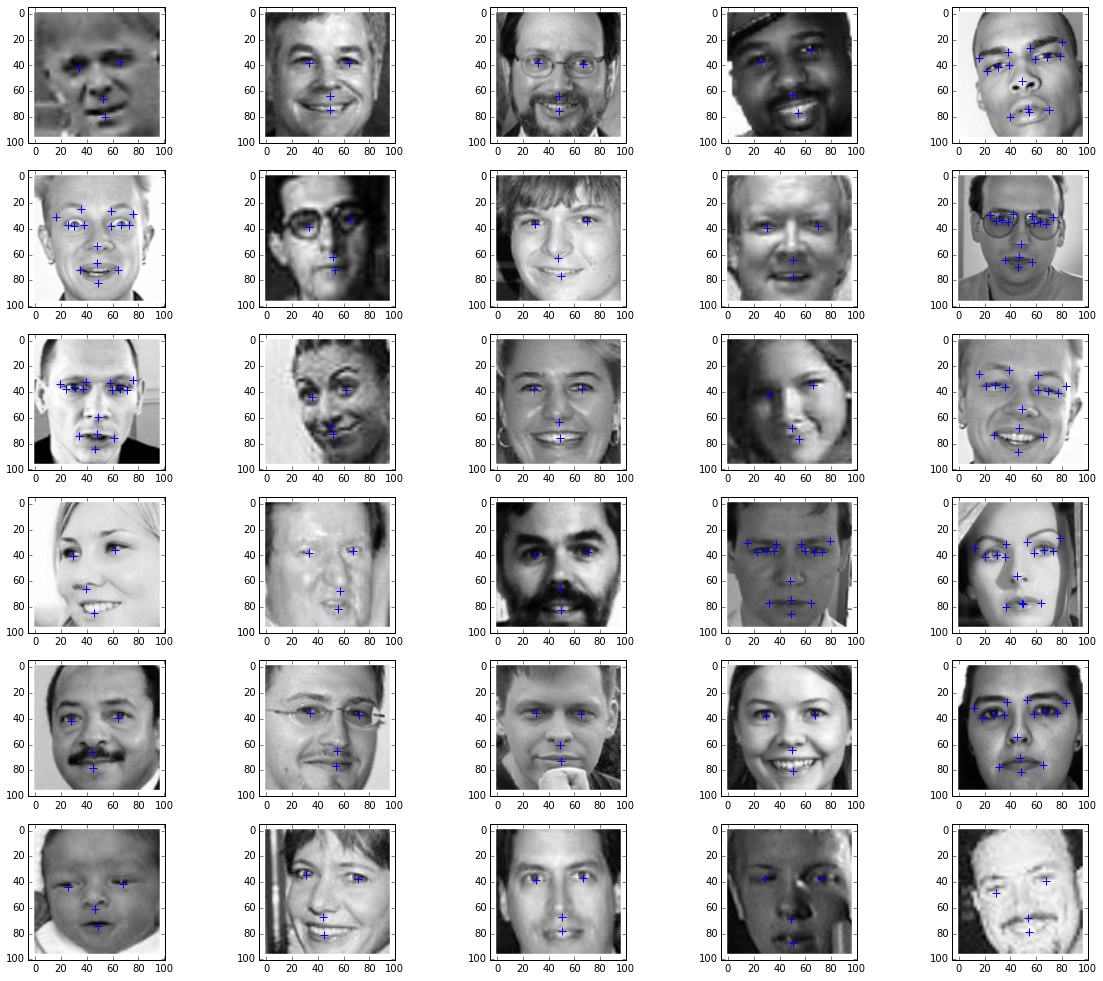

'picsplz' took 2.60 seconds


In [28]:
# Define some utility functions

# Build the feature name -> idx and idx -> feature_name mappings for easy translation
feature_dict = {}
idx_dict = {}

# Read the first entry in training.csv and split by commas
with open("training.csv", "r") as f:
  header = f.readline().strip().split(",")[:-1]
  feature_dict = dict(enumerate(header))
  idx_dict = { v: k for k, v in feature_dict.items() }

def stopwatch(f):
  """for timing stuff"""
  def timer(*args, **kw):
    start = time.time()
    result = f(*args, **kw)
    end = time.time()
    print '%r took %.2f seconds' % (f.__name__, end-start)
    return result

  return timer

@stopwatch
def picsplz(idxs, train_data = train_data, train_labels = train_labels, pred_labels = [], cols = 5):
  """given a list of indices, draws the images and their facial keypoints"""
  plt.figure(figsize = (20, 20))
  for i, j in enumerate(idxs):
    ax = plt.subplot(1 + (len(idxs) / cols), cols, i+1)
    x = train_data[j].reshape(96, 96)
    ax.imshow(x, cmap = "gray")
    # TODO expand this to color dot based on type of keypoint
    ax.scatter((train_labels[j][0::2] * 48) + 48, (train_labels[j][1::2] * 48) + 48, s=50, marker="+")
    # if we have predicted labels, then display them as red dots
    if len(pred_labels) > j:
      ax.scatter((pred_labels[j][0::2] * 48) + 48, (pred_labels[j][1::2] * 48) + 48, s=50, c="red", marker="+")
  plt.show()

def rmse(pred_labels, actual_labels):
  """compute rmse"""
  # set all missing features to 0 when doing rmse computation

  cases = ~np.isnan(actual_labels)
  return np.sqrt(mean_squared_error(actual_labels[cases], pred_labels[cases]))

# Sanity check: print out our feature dictionary
print feature_dict

# Show 30 random samples
picsplz(np.random.permutation(np.arange(len(train_data)))[:30])


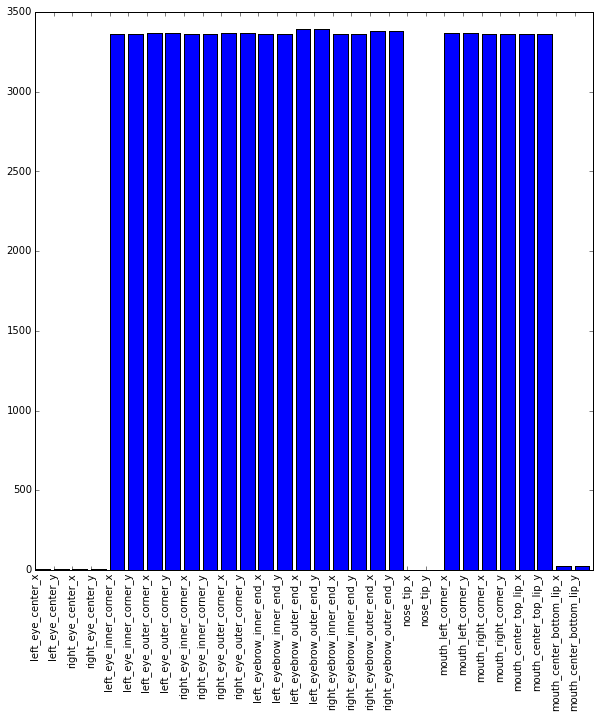

Number of complete cases: 1552


In [4]:
# Visualize number of occurrences of each keypoint
nans_per_keypoint = np.sum(np.isnan(train_labels.T), axis=1)
plt.figure(figsize=(10, 10))
plt.bar(range(30), nans_per_keypoint)
plt.xticks(range(30), feature_dict.values(), rotation='vertical')
plt.show()

# Print the number of complete cases
complete_cases = np.equal(np.sum(np.logical_not(np.isnan(train_labels)), axis=1), 30)
print "Number of complete cases: %d" % np.sum(complete_cases)

In [29]:
# Do some feature engineering.
# Expand out our training set with rotations

from scipy import ndimage
from scipy import misc

def label_rotation(theta, z):
    '''Rotation function for the facial keypoints'''
    # theta is an angle in radians
    # z represents the x and y coordinates of a facial keypoint
    rot = np.mat([[np.cos(theta), -1.0 * np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    return (rot * np.mat(z * 48.0).T) / 48
    
def label_reflection(z):
    '''Reflection function for the facial keypoints'''
    #z represents the x and y coordinates of a facial keypoint
    ref = np.mat([[-1.0, 0.0], [0.0, 1.0]])
    return ref * np.mat(z).T

def gen_features(train_data, train_labels):
    #==================================================================================#
    ##### ----- Apply transformations ----- #####

    ### --- Rotate all images cw and ccw by 15 degrees --- ###
    train_data_cw = np.zeros((len(train_data), 96*96), dtype=np.float32)
    train_data_ccw = np.zeros((len(train_data), 96*96), dtype=np.float32)
    train_data_ref = np.zeros((len(train_data), 96*96), dtype=np.float32)

    for i, k in enumerate(train_data):
        #Reshape to 2D array to apply transforms
        image = np.reshape(k,(96,96))
        #Apply transforms
        # Apply clockwise transformation
        cw = ndimage.rotate(image, 15, reshape=False)
        cw = np.reshape(cw, (9216,))
        train_data_cw[i, :] = cw

        # Apply counterclockwise transformation
        ccw = ndimage.rotate(image, -15, reshape=False)
        ccw = np.reshape(ccw, (9216,))
        #Assign to appropriate training sets
        train_data_ccw[i, :] = ccw

        # Apply reflection
        trans = np.transpose(image)
        rot = ndimage.rotate(trans, -90, reshape=False)
        ref = np.reshape(rot,(9216,))
        train_data_ref[i, :] = ref
        
    ### --- Stack the constructed training sets one-ontop-another --- ###
    new_train_data = np.vstack((train_data, train_data_cw, train_data_ccw, train_data_ref))
    print len(new_train_data)

    ### --- Transform all labels appropriately --- ###
    train_labels_cw = np.zeros((len(train_data), 30), dtype=np.float32)
    train_labels_ccw = np.zeros((len(train_data), 30), dtype=np.float32)
    train_labels_ref = np.zeros((len(train_data), 30), dtype=np.float32)

    for k in range(0,len(train_labels)):
        for j in range(0, 30, 2):
            # Pick out the particular x and y coordinate of a facial keypoint
            xy = train_labels[k, j:j+2]
            
            # Rotate the label and assign to a new coordinate
            cw = label_rotation(-1 * np.pi / 12.0, xy)
            ccw = label_rotation(np.pi / 12.0, xy)

            # Reflect the label
            ref = label_reflection(xy)

            #Assign to the new label array
            train_labels_cw[k, j:j+2] = cw.T.tolist()[0]
            train_labels_ccw[k, j:j+2] = ccw.T.tolist()[0]
            train_labels_ref[k, j:j+2] = ref.T.tolist()[0]

    tl = train_labels
    cw = np.array(train_labels_cw)
    ccw = np.array(train_labels_ccw)
    ref = np.array(train_labels_ref)
    
    new_train_labels = np.vstack((train_labels, train_labels_cw, train_labels_ccw, train_labels_ref))

    return (new_train_data, new_train_labels)

train_data, train_labels = gen_features(train_data, train_labels)

20000


In [ ]:
from theano.tensor.nnet import conv2d

def edge_detection(img):


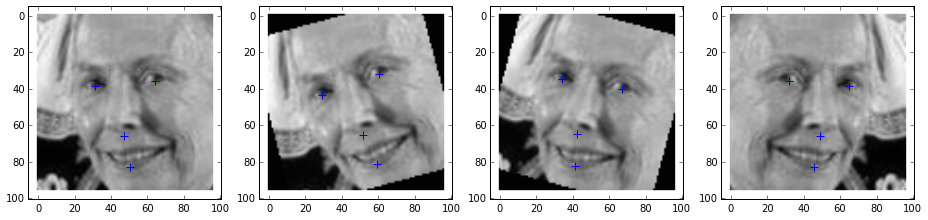

'picsplz' took 0.45 seconds


In [30]:
# Check on one image whether or not the rotations and the reflections worked
picsplz(map(lambda x: x + 8, [0, 5000, 10000, 15000]), train_data, train_labels)

In [69]:
from theano.tensor.nnet import conv2d
from lasagne import layers
from lasagne.updates import nesterov_momentum
from nolearn.lasagne import NeuralNet
from nolearn.lasagne import BatchIterator

# Define our early stopping criteria
# Credit to Daniel Nouri goes here
class AdjustVariable(object):
    def __init__(self, name, start=0.03, stop=0.001):
        self.name = name
        self.start, self.stop = start, stop
        self.ls = None

    def __call__(self, nn, train_history):
        if self.ls is None:
            self.ls = np.linspace(self.start, self.stop, nn.max_epochs)

        epoch = train_history[-1]['epoch']
        new_value = np.cast['float32'](self.ls[epoch - 1])
        getattr(nn, self.name).set_value(new_value)

class EarlyStopping(object):
    def __init__(self, patience=100):
        self.patience = patience
        self.best_valid = np.inf
        self.best_valid_epoch = 0
        self.best_weights = None

    def __call__(self, nn, train_history):
        current_valid = train_history[-1]['valid_loss']
        current_epoch = train_history[-1]['epoch']
        if current_valid < self.best_valid:
            self.best_valid = current_valid
            self.best_valid_epoch = current_epoch
            self.best_weights = [w.get_value() for w in nn.get_all_params()]
        elif self.best_valid_epoch + self.patience < current_epoch:
            print "stopping early"
            print "Best valid loss was %.4f at epoch %d." % (self.best_valid, self.best_valid_epoch)
            nn.load_weights_from(self.best_weights)
            raise StopIteration()

@stopwatch
def model(**kwargs):
    train_data = kwargs['train_data']
    train_labels = kwargs['train_labels']
    idxs = kwargs['idxs'] if 'idxs' in kwargs else np.equal(np.sum(np.logical_not(np.isnan(train_labels)), axis=1), 30)
    test_data = kwargs['test_data']
    verbose = kwargs['verbose'] if 'verbose' in kwargs else 0
    pre_train = kwargs['pre_train'] if 'pre_train' in kwargs else None
    output_num_units = kwargs['output_num_units'] if 'output_num_units' in kwargs else 30

    nn = NeuralNet(
        layers=[  # three layers: one hidden layer
            ('input', layers.InputLayer),
            ('conv1', layers.Conv2DLayer),
            ('pool1', layers.MaxPool2DLayer),
            ('conv2', layers.Conv2DLayer),
            ('pool2', layers.MaxPool2DLayer),
            ('conv3', layers.Conv2DLayer),
            ('pool3', layers.MaxPool2DLayer),
            ('conv4', layers.Conv2DLayer),
            ('pool4', layers.MaxPool2DLayer),
            ('hidden4', layers.DenseLayer),
            ('hidden5', layers.DenseLayer),
            ('output', layers.DenseLayer)
        ],
        # layer parameters:
        input_shape=(None, 1, 96, 96),
        conv1_num_filters=32, conv1_filter_size=(3, 3), conv1_convolution=conv2dpool1_ds=(2, 2),
        conv2_num_filters=32, conv2_filter_size=(3, 3), pool2_ds=(2, 2),
        conv3_num_filters=64, conv3_filter_size=(2, 2), pool3_ds=(2, 2),
        conv4_num_filters=128, conv4_filter_size=(2, 2), pool4_ds=(2, 2),
        hidden4_num_units=500,
        hidden5_num_units=500,
        output_num_units=output_num_units,
        output_nonlinearity=None,

        # optimization method:
        update=nesterov_momentum,
        update_learning_rate=theano.shared(np.float32(0.03)),
        update_momentum=theano.shared(np.float32(0.9)),

        # early stopping criteria
        on_epoch_finished=[
            AdjustVariable('update_learning_rate', start=0.03, stop=0.0001),
            AdjustVariable('update_momentum', start=0.9, stop=0.999),
            EarlyStopping(patience=200),
        ],
        
        regression=True,
        batch_iterator_train=BatchIterator(batch_size=128),
        max_epochs=1000,
        verbose=verbose
        )

    if pre_train is not None:
        nn.load_weights_from(pre_train)
    
    X = train_data[idxs].reshape(-1, 1, 96, 96)
    y = train_labels[idxs]
    
    nn.fit(X, y)
    pred_labels = nn.predict(test_data.reshape(-1, 1, 96, 96)) 
    
    return (nn, pred_labels)

0.0853482


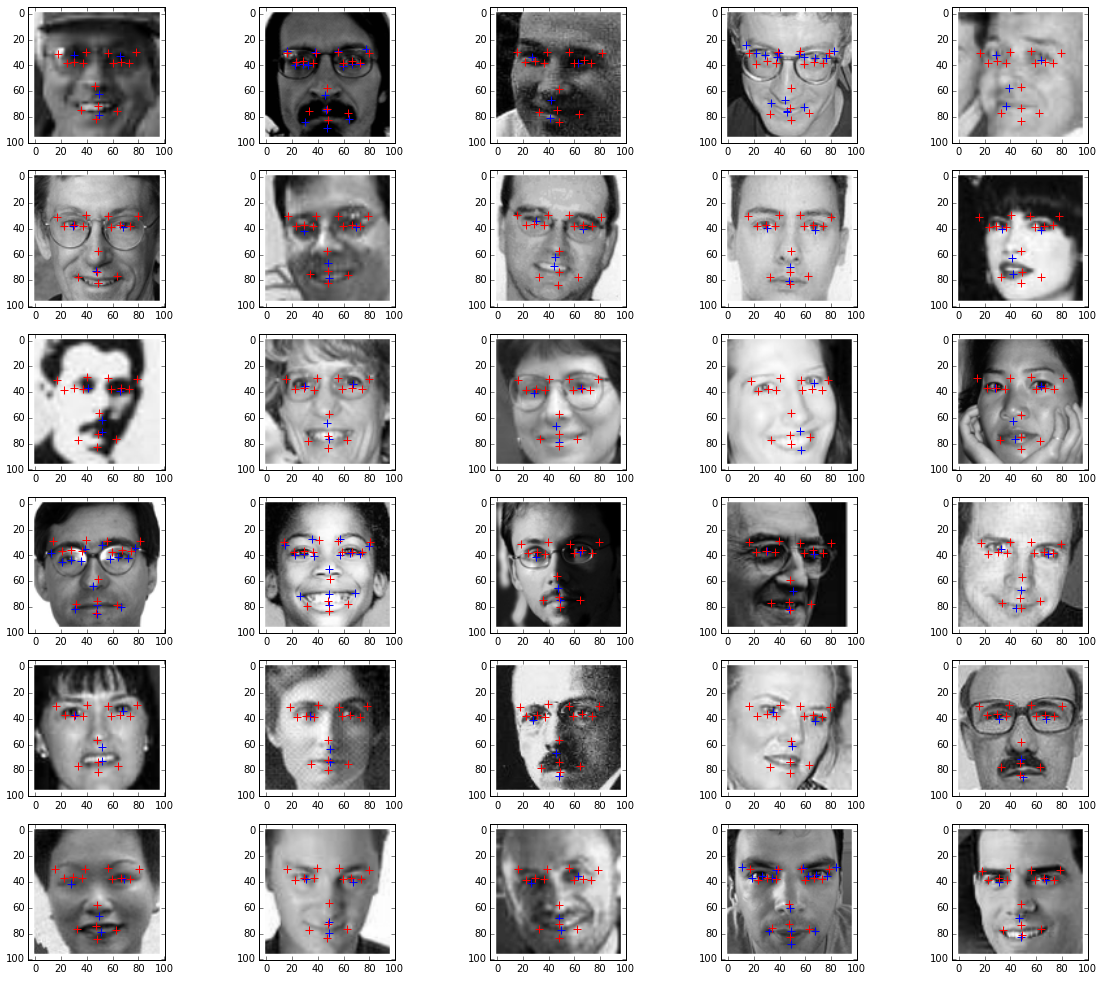

'picsplz' took 2.87 seconds


In [33]:
m, pred_labels = model(train_data = train_data[:500], train_labels = train_labels[:500], test_data = dev_data, verbose = 0)
print rmse(pred_labels, dev_labels)

picsplz(np.random.permutation(np.arange(len(dev_labels)))[:30], dev_data, dev_labels, pred_labels)

In [70]:
@stopwatch
def specialists_model(**kwargs):
    train_data = kwargs['train_data']
    train_labels = kwargs['train_labels']
    test_data = kwargs['test_data']
    verbose = kwargs['verbose'] if 'verbose' in kwargs else 0
    pre_train = kwargs['pre_train']
    
    def cols_for(feat_names):
        return [ idx_dict[x] for x in feat_names ]
    
    def cases_for(feat_cols):
        return np.equal(np.sum(np.logical_not(np.isnan(train_labels[:, feat_cols])), axis=1), len(feat_cols))

    # Build our input data for each of the specialists
    specialists = {}
    feats = ['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x', 'right_eye_center_y']
    cols = cols_for(feats)
    idxs = cases_for(cols)
    specialists['eye'] = (feats, cols, idxs)
    
    feats = ['left_eye_inner_corner_x', 'left_eye_inner_corner_y', 'left_eye_outer_corner_x', 'left_eye_outer_corner_y', 'right_eye_inner_corner_x', 'right_eye_inner_corner_y', 'right_eye_outer_corner_x', 'right_eye_outer_corner_y']
    cols = cols_for(feats)
    idxs = cases_for(cols)
    specialists['eye_detail'] = (feats, cols, idxs)
    
    feats = ['left_eyebrow_inner_end_x', 'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x', 'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x', 'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x', 'right_eyebrow_outer_end_y']
    cols = cols_for(feats)
    idxs = cases_for(cols)
    specialists['eyebrow'] = (feats, cols, idxs)
    
    feats = ['nose_tip_x', 'nose_tip_y']
    cols = cols_for(feats)
    idxs = cases_for(cols)
    specialists['nose'] = (feats, cols, idxs)
    
    feats = ['mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x', 'mouth_right_corner_y', 'mouth_center_top_lip_x', 'mouth_center_top_lip_y']
    cols = cols_for(feats)
    idxs = cases_for(cols)
    specialists['mouth_detail'] = (feats, cols, idxs)
    
    feats = ['mouth_center_bottom_lip_x', 'mouth_center_bottom_lip_y']
    cols = cols_for(feats)
    idxs = cases_for(cols)
    specialists['mouth'] = (feats, cols, idxs)
    
    models = {}
    pred_labels = np.zeros((test_data.shape[0], 30))
    for i, (name, (feats, cols, idxs)) in enumerate(specialists.iteritems()):
        print "(%d/%d) training %s specialist against %d samples" % (i+1, len(specialists), name, len(idxs))
        # For each specialist, train against complete cases for each of the specialists' features
        nn, ff = model(
            train_data = train_data,
            train_labels = train_labels[:, cols],
            idxs = idxs,
            test_data = test_data,
            output_num_units = len(feats),
            pre_train = pre_train,
            verbose = verbose)
        
        # Save our specialist for later
        models[name] = nn
        
        # Fill in the predicted values in the correct columns
        pred_labels[:, cols] = ff

    return (models, pred_labels)


(0/6) training eye specialist against 100 samples
stopping early
Best valid loss was 0.0028 at epoch 246.
(1/6) training mouth_detail specialist against 100 samples
stopping early
Best valid loss was 0.0082 at epoch 108.
(2/6) training eyebrow specialist against 100 samples
stopping early
Best valid loss was 0.0039 at epoch 11.
(3/6) training mouth specialist against 100 samples
stopping early
Best valid loss was 0.0080 at epoch 112.
(4/6) training nose specialist against 100 samples
stopping early
Best valid loss was 0.0098 at epoch 9.
(5/6) training eye_detail specialist against 100 samples
stopping early
Best valid loss was 0.0023 at epoch 8.
0.0792506016467


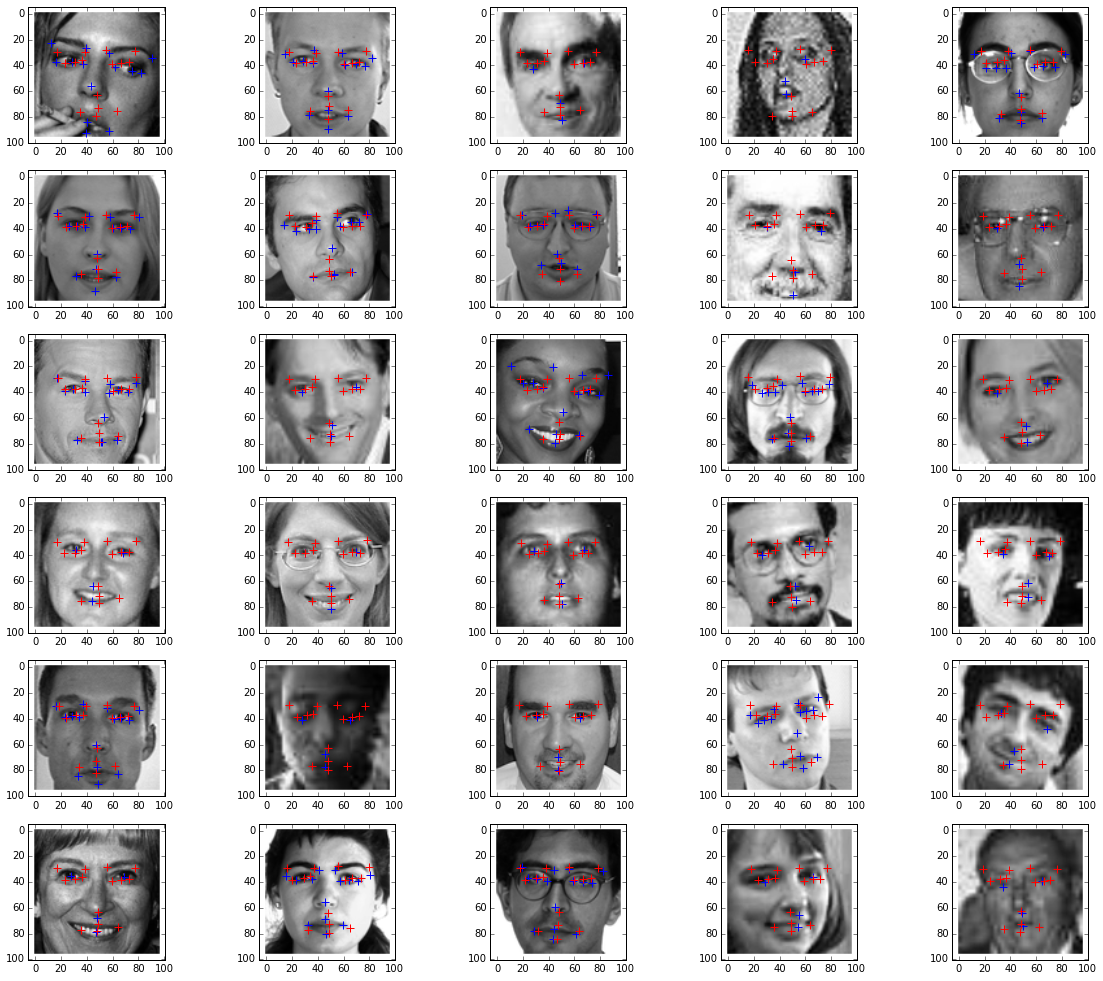

'picsplz' took 3.32 seconds


In [67]:
# Sanity check to make sure its working against a small dataset
sm, pred_labels = specialists_model(
    train_data = train_data[:100],
    train_labels = train_labels[:100],
    pre_train = m,
    test_data = dev_data,
    verbose = 0)

print rmse(pred_labels, dev_labels)

picsplz(np.random.permutation(np.arange(len(dev_labels)))[:30], dev_data, dev_labels, pred_labels)

In [68]:
@stopwatch
def kaggleize(output, labels):
  """given a set of labels for the test set, output our results in the expected kaggle format"""

  assert len(labels) == 1783, "Expecting 1783 labels, found %d" % len(labels)

  with open("IdLookupTable.csv", "r") as f_in, open(output, "w") as f_out:
    # Skip first line, since it's the header
    f_in.readline()

    f_out.write("RowId,Location\n")
    for line in f_in:
      entry = line.strip().split(",")
      row = int(entry[0])
      idx = int(entry[1])
      feature = entry[2]
      location = round((labels[idx-1, idx_dict[feature]] * 48) + 48)
      # max value is 96 and min value is 0
      # rescale to the appropriate
      bounded_location = max(0, min(96, location))
      f_out.write("%d,%d\n" % (row, bounded_location))

In [71]:
# Evaluate our specialist model against the entire training set and generate sample set
# Train our model
m, pred_labels = specialists_model(
    train_data = all_train_data,
    train_labels = all_train_labels,
    test_data = kaggle_test_data,
    pre_train = m)

# Output our baseline results to kaggle format
kaggleize("output.csv", pred_labels)

# Profit!
print "done!"

(0/6) training eye specialist against 7049 samples
stopping early
Best valid loss was 0.0011 at epoch 162.
'model' took 2291.86 seconds
(1/6) training mouth_detail specialist against 7049 samples
stopping early
Best valid loss was 0.0009 at epoch 547.
'model' took 1524.92 seconds
(2/6) training eyebrow specialist against 7049 samples
'model' took 1973.66 seconds
(3/6) training mouth specialist against 7049 samples
stopping early
Best valid loss was 0.0052 at epoch 210.
'model' took 2590.59 seconds
(4/6) training nose specialist against 7049 samples
stopping early
Best valid loss was 0.0095 at epoch 440.
'model' took 4058.71 seconds
(5/6) training eye_detail specialist against 7049 samples
'model' took 2032.29 seconds
'specialists_model' took 14472.04 seconds
0.102050224213
'kaggleize' took 0.12 seconds
done!
